# Proyecto: Reconocimiento de Lenguaje de Señas Americano (ASL)

## Notebook 03: Preprocesamiento de Datos

**Objetivo:** Preparar los datos de manera óptima para el entrenamiento de modelos profundos, incluyendo estrategias avanzadas de aumento de datos que simulen condiciones de webcam real.

**Contenido:**
1. Normalización y estandarización
2. Data Augmentation robusto (rotación, zoom, brillo, contraste)
3. Técnicas de balanceo de clases
4. Generación de conjuntos de validación
5. Preprocesamiento específico para Transfer Learning
6. Guardado de datasets procesados

---

## 0. Importaciones y Configuración

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json

# Importaciones de TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importaciones de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    print("Ejecutando en Google Colab. Montando Drive...")
    drive.mount('/content/drive')

    # RUTA
    PROJECT_ROOT = Path('/content/drive/MyDrive/proyecto-app-lenguaje-senas')

    if not PROJECT_ROOT.exists():
        print(f"Carpeta no encontrada en {PROJECT_ROOT}!")
    else:
        os.chdir(PROJECT_ROOT)
        if str(PROJECT_ROOT) not in sys.path:
            sys.path.append(str(PROJECT_ROOT))
        print(f"Entorno Colab configurado. Directorio: {os.getcwd()}")
else:
    # Entorno Local
    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    os.chdir(PROJECT_ROOT)
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.append(str(PROJECT_ROOT))
    print(f"Entorno Local configurado. Directorio: {os.getcwd()}")

Ejecutando en Google Colab. Montando Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Entorno Colab configurado. Directorio: /content/drive/MyDrive/proyecto-app-lenguaje-senas


## 1. Carga de Datos

In [2]:
# Configuración de directorios usando la ruta persistente
BASE_DIR = str(PROJECT_ROOT)

if IN_COLAB:
    print(f"Ejecutando en Colab - Usando Drive: {BASE_DIR}")
else:
    print(f"Ejecutando localmente - Directorio: {BASE_DIR}")

# Rutas
DATA_RAW = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROCESSED = os.path.join(BASE_DIR, 'data', 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'results', 'figures')

# Cargar datos
train_df = pd.read_csv(os.path.join(DATA_RAW, 'sign_mnist_train.csv'))
test_df = pd.read_csv(os.path.join(DATA_RAW, 'sign_mnist_test.csv'))

# Separar features y labels
X_train_raw = train_df.drop('label', axis=1).values
y_train_raw = train_df['label'].values
X_test_raw = test_df.drop('label', axis=1).values
y_test_raw = test_df['label'].values

print(f"Datos de entrenamiento: {X_train_raw.shape}")
print(f"Datos de prueba: {X_test_raw.shape}")

# Mapeo de etiquetas (omitiendo 9=J y 25=Z del dataset original)
label_to_letter = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}

Ejecutando en Colab - Usando Drive: /content/drive/MyDrive/proyecto-app-lenguaje-senas
Datos de entrenamiento: (27455, 784)
Datos de prueba: (7172, 784)


## 2. Normalización de Datos

In [3]:
# Normalización [0, 1] - estándar para imágenes
X_train_norm = X_train_raw / 255.0
X_test_norm = X_test_raw / 255.0

# Reshape a formato de imagen (28, 28, 1)
X_train = X_train_norm.reshape(-1, 28, 28, 1)
X_test = X_test_norm.reshape(-1, 28, 28, 1)

# One-Hot Encoding de etiquetas
y_train = to_categorical(y_train_raw, num_classes=25)
y_test = to_categorical(y_test_raw, num_classes=25)

print(f"X_train normalizado: {X_train.shape}, rango: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"y_train one-hot: {y_train.shape}")
print(f"\nDatos listos para entrenamiento de CNN")

X_train normalizado: (27455, 28, 28, 1), rango: [0.00, 1.00]
y_train one-hot: (27455, 25)

Datos listos para entrenamiento de CNN


## 3. Creación de Conjunto de Validación

In [7]:
# Dividir training en train y validation (80-20)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train_raw  # Mantener proporción de clases
)

print(f"Training set: {X_train_split.shape[0]:,} muestras")
print(f"Validation set: {X_val.shape[0]:,} muestras")
print(f"Test set: {X_test.shape[0]:,} muestras")
print(f"\nProporción: {X_train_split.shape[0]/(X_train_split.shape[0]+X_val.shape[0])*100:.1f}% - {X_val.shape[0]/(X_train_split.shape[0]+X_val.shape[0])*100:.1f}%")

Training set: 21,964 muestras
Validation set: 5,491 muestras
Test set: 7,172 muestras

Proporción: 80.0% - 20.0%


## 4. Data Augmentation Avanzado (Crítico para Webcam)

### 4.1 Configuración de ImageDataGenerator con Augmentación Robusta

In [14]:
# Simular condiciones de webcam
train_datagen = ImageDataGenerator(
    rotation_range=20,              # Rotación hasta ±20° (más conservador)
    zoom_range=0.15,                # Zoom de ±15% (más conservador)
    width_shift_range=0.15,         # Desplazamiento horizontal
    height_shift_range=0.15,        # Desplazamiento vertical
    shear_range=0.1,                # Cizallamiento (ángulo de cámara)
    fill_mode='nearest',            # Rellenar con píxeles cercanos
    horizontal_flip=False,          # NO voltear (cambiaría el significado de la seña)
    vertical_flip=False
)

# Validación y test SIN augmentación
val_test_datagen = ImageDataGenerator()

print("Data augmentation configurado exitosamente")
print("\nTransformaciones aplicadas:")
print("  - Rotación aleatoria: ±20°")
print("  - Zoom aleatorio: ±15%")
print("  - Desplazamientos: ±15%")
print("  - Cizallamiento: ±10°")

Data augmentation configurado exitosamente

Transformaciones aplicadas:
  - Rotación aleatoria: ±20°
  - Zoom aleatorio: ±15%
  - Desplazamientos: ±15%
  - Cizallamiento: ±10°


### 4.2 Visualización de Augmentación

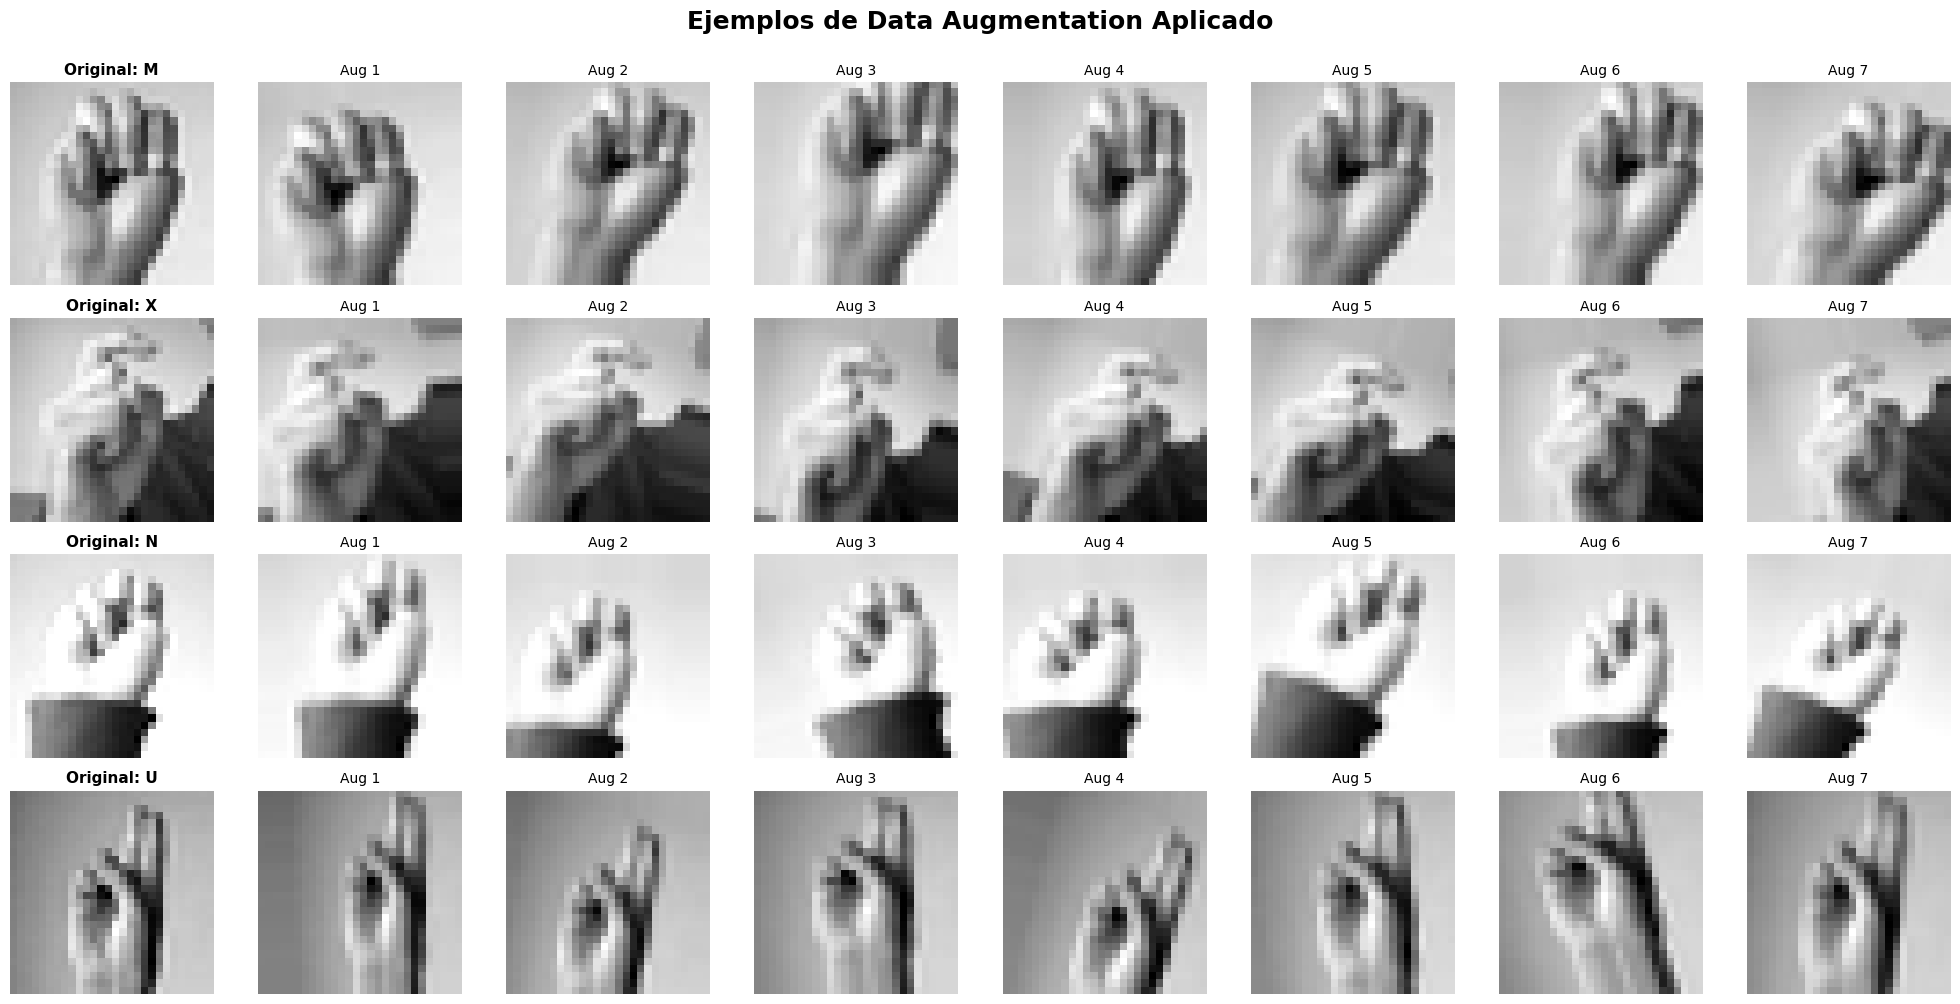


El augmentation simula:
  - Diferentes ángulos de cámara
  - Variaciones de distancia a la cámara
  - Condiciones de iluminación variables (oficina, casa, exterior)
  - Posición variable de la mano en el frame


In [15]:
# Visualizar efecto del data augmentation
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Seleccionar 4 imágenes aleatorias
for row in range(4):
    idx = np.random.randint(0, len(X_train_split))
    sample = X_train_split[idx:idx+1]
    label_idx = np.argmax(y_train_split[idx])
    letter = label_to_letter[label_idx]

    # Imagen original
    axes[row, 0].imshow(sample[0, :, :, 0], cmap='gray')
    axes[row, 0].set_title(f'Original: {letter}', fontweight='bold', fontsize=11)
    axes[row, 0].axis('off')
    axes[row, 0].set_facecolor('lightblue')

    # 7 versiones aumentadas
    aug_iter = train_datagen.flow(sample, batch_size=1)
    for col in range(1, 8):
        aug_img = next(aug_iter)[0, :, :, 0]
        axes[row, col].imshow(aug_img, cmap='gray')
        axes[row, col].set_title(f'Aug {col}', fontsize=10)
        axes[row, col].axis('off')

plt.suptitle('Ejemplos de Data Augmentation Aplicado', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '03_data_augmentation_examples.png'), dpi=200, bbox_inches='tight')
plt.show()

print("\nEl augmentation simula:")
print("  - Diferentes ángulos de cámara")
print("  - Variaciones de distancia a la cámara")
print("  - Condiciones de iluminación variables (oficina, casa, exterior)")
print("  - Posición variable de la mano en el frame")

### 4.3 Augmentación Adicional Personalizada

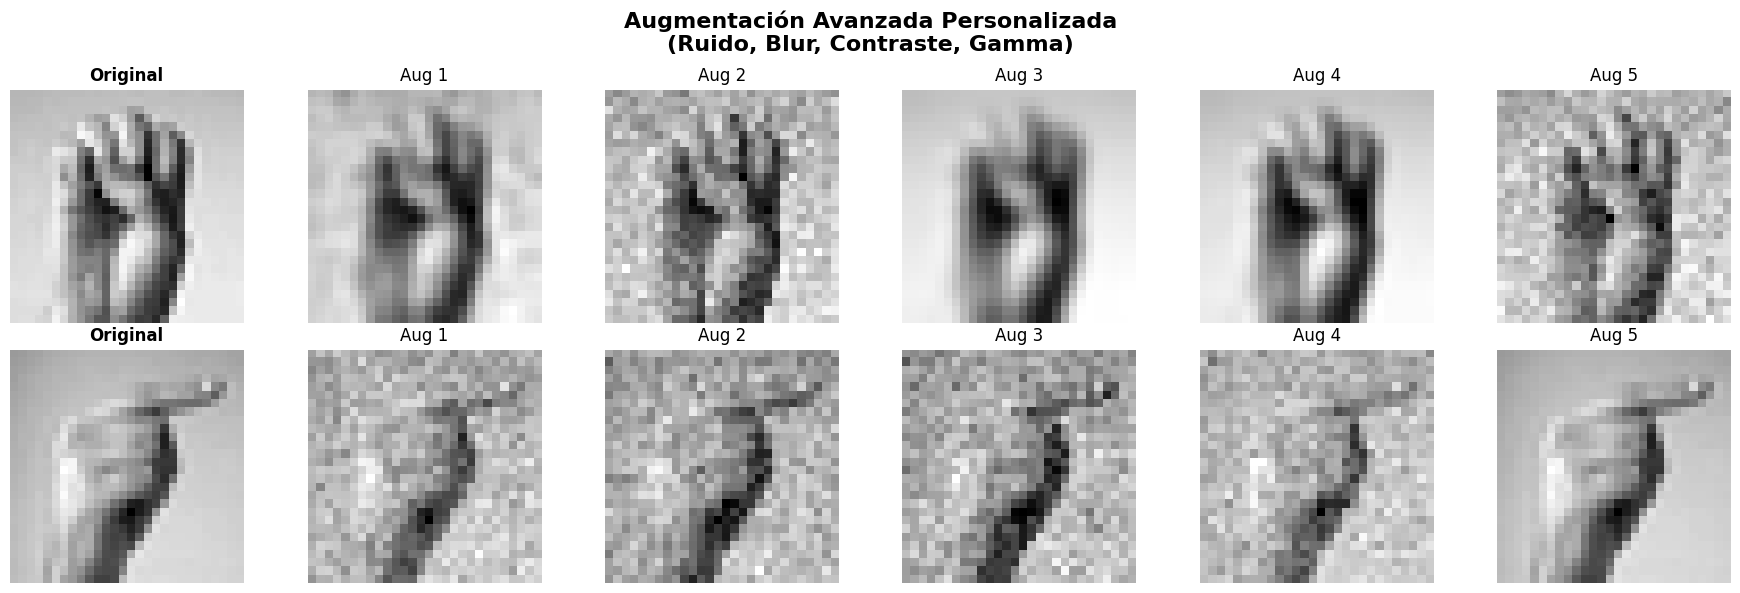

In [16]:
def apply_advanced_augmentation(image, intensity=0.3):
    """
    Aplica transformaciones adicionales no disponibles en ImageDataGenerator.
    Especialmente útil para simular condiciones de webcam real.
    """
    img = image.copy().reshape(28, 28)

    # Aplicar transformaciones aleatorias
    if np.random.random() < intensity:
        # 1. Ruido gaussiano (sensor de cámara)
        noise = np.random.normal(0, 0.05, img.shape)
        img = np.clip(img + noise, 0, 1)

    if np.random.random() < intensity:
        # 2. Blur (desenfoque de movimiento)
        kernel_size = np.random.choice([3, 5])
        img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    if np.random.random() < intensity:
        # 3. Ajuste de contraste
        factor = np.random.uniform(0.7, 1.3)
        img = np.clip((img - 0.5) * factor + 0.5, 0, 1)

    if np.random.random() < intensity:
        # 4. Ajuste de gamma (simular diferentes exposiciones)
        gamma = np.random.uniform(0.7, 1.3)
        img = np.power(img, gamma)

    return img.reshape(28, 28, 1)

# Demostración
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(2):
    idx = np.random.randint(0, len(X_train_split))
    original = X_train_split[idx]

    axes[i, 0].imshow(original[:, :, 0], cmap='gray')
    axes[i, 0].set_title('Original', fontweight='bold')
    axes[i, 0].axis('off')

    for j in range(1, 6):
        augmented = apply_advanced_augmentation(original, intensity=0.5)
        axes[i, j].imshow(augmented[:, :, 0], cmap='gray')
        axes[i, j].set_title(f'Aug {j}')
        axes[i, j].axis('off')

plt.suptitle('Augmentación Avanzada Personalizada\n(Ruido, Blur, Contraste, Gamma)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '03_advanced_augmentation.png'), dpi=200, bbox_inches='tight')
plt.show()

## 5. Cálculo de Pesos de Clase (Class Weights)

Clases encontradas en dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]


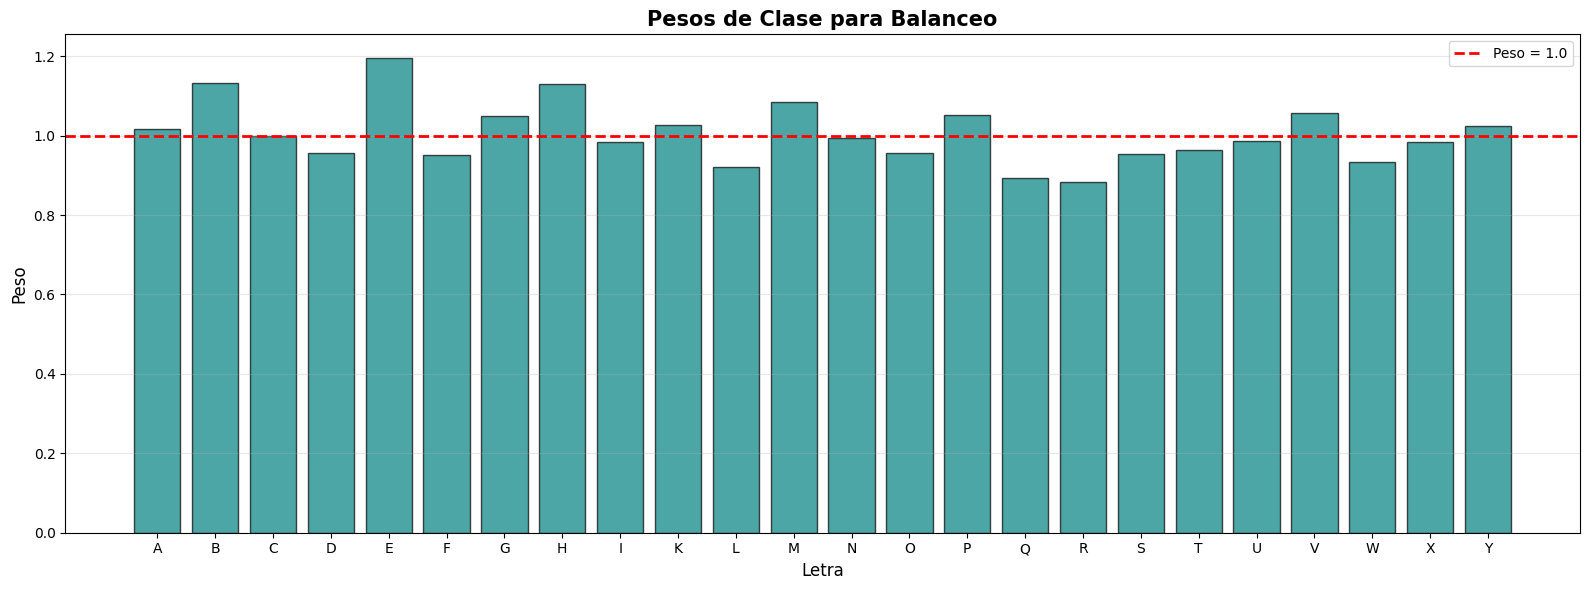

Pesos de clase calculados:
  A: 1.0159
  B: 1.1326
  C: 1.0000
  D: 0.9565
  E: 1.1954
  F: 0.9501
  G: 1.0495
  H: 1.1293
  I: 0.9845
  K: 1.0269
  L: 0.9218
  M: 1.0843
  N: 0.9939
  O: 0.9565
  P: 1.0514
  Q: 0.8944
  R: 0.8840
  S: 0.9541
  T: 0.9646
  U: 0.9853
  V: 1.0573
  W: 0.9338
  X: 0.9828
  Y: 1.0232


In [17]:
# Calcular pesos de clase para manejar cualquier desbalance
# Obtener las clases únicas del dataset (omitiendo 9 y 25 automáticamente)
unique_labels = np.unique(y_train_raw)
print(f"Clases encontradas en dataset: {sorted(unique_labels)}")

# Calcular pesos de clase
class_weights_array = compute_class_weight(
    'balanced',
    classes=unique_labels,
    y=y_train_raw
)

# Mapear pesos a las etiquetas reales (no secuenciales como 0-8, 10-24)
class_weights = dict(zip(unique_labels, class_weights_array))

# Visualizar
plt.figure(figsize=(16, 6))
# Asegurarse de usar solo las letras que corresponden a las clases presentes
letters = [label_to_letter[label] for label in sorted(unique_labels)]
weights = [class_weights[label] for label in sorted(unique_labels)]

plt.bar(letters, weights, color='teal', alpha=0.7, edgecolor='black')
plt.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Peso = 1.0')
plt.title('Pesos de Clase para Balanceo', fontsize=15, fontweight='bold')
plt.xlabel('Letra', fontsize=12)
plt.ylabel('Peso', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '03_class_weights.png'), dpi=200, bbox_inches='tight')
plt.show()

print("Pesos de clase calculados:")
for label in sorted(unique_labels):
    print(f"  {label_to_letter[label]}: {class_weights[label]:.4f}")

## 6. Preprocesamiento para Transfer Learning

Preparando datos para Transfer Learning...
Usando tamaño 96x96
Procesando conjunto de ENTRENAMIENTO...
  Procesadas 3000/21964 imágenes...
  Procesadas 6000/21964 imágenes...
  Procesadas 9000/21964 imágenes...
  Procesadas 12000/21964 imágenes...
  Procesadas 15000/21964 imágenes...
  Procesadas 18000/21964 imágenes...
  Procesadas 21000/21964 imágenes...
  Procesadas 21964/21964 imágenes...

Procesando conjunto de VALIDACIÓN...
  Procesadas 3000/5491 imágenes...
  Procesadas 5491/5491 imágenes...

Procesando conjunto de TEST...
  Procesadas 3000/7172 imágenes...
  Procesadas 6000/7172 imágenes...
  Procesadas 7172/7172 imágenes...

Datos para Transfer Learning (96x96)
  Train: (21964, 96, 96, 3) - Tamaño: 2.26 GB
  Val: (5491, 96, 96, 3) - Tamaño: 0.57 GB
  Test: (7172, 96, 96, 3) - Tamaño: 0.74 GB


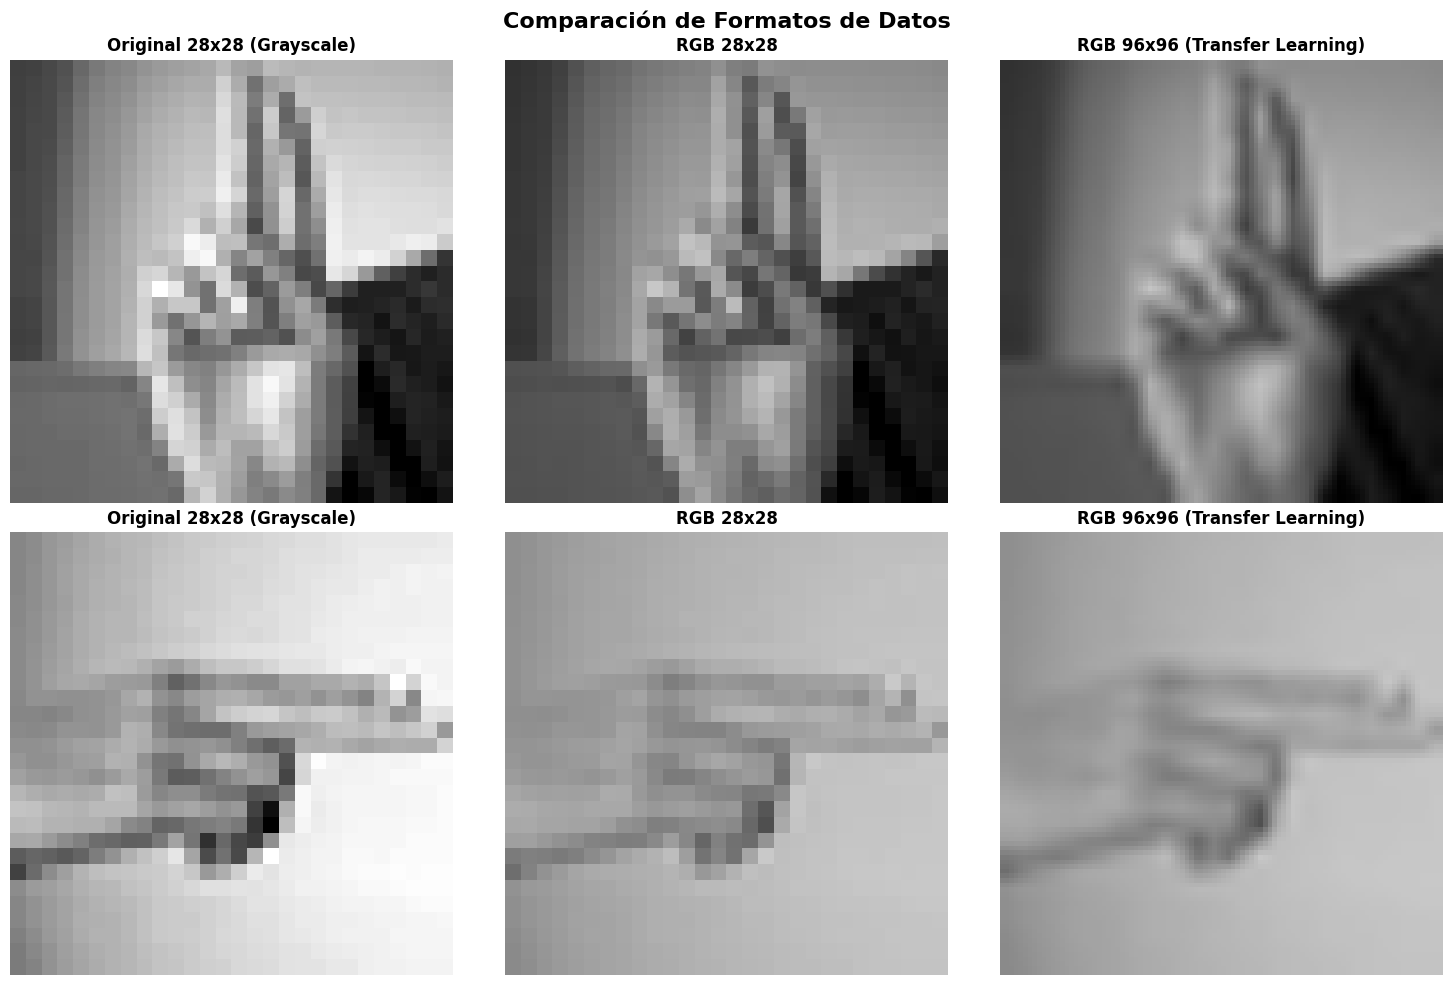

In [19]:
# Gestión de memoria para Colab
import gc

# Para modelos preentrenados que esperan imágenes RGB
def prepare_for_transfer_learning(X, target_size=(96, 96), batch_size=150):
    """
    Prepara imágenes para modelos pre-entrenados procesando en batches PEQUEÑOS
    1. Convierte grayscale a RGB (3 canales)
    2. Redimensiona a tamaño requerido

    Args:
        X: Datos de entrada (N, 28, 28, 1)
        target_size: Tamaño destino (recomendado 96x96 para Colab, más liviano que 128x128)
        batch_size: Procesar en batches pequeños (150) para evitar OOM
    """
    n_samples = X.shape[0]
    height, width = target_size

    # Preasignar el array final para mayor eficiencia
    X_resized = np.zeros((n_samples, height, width, 3), dtype=np.float32)

    # Procesar en batches pequeños para gestionar memoria
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_size_actual = end_idx - start_idx

        # Procesar muestra por muestra para máxima eficiencia de memoria
        for i, img_idx in enumerate(range(start_idx, end_idx)):
            # Tomar una imagen a la vez
            img = X[img_idx, :, :, 0]

            # Convertir a RGB (repetir el canal)
            img_rgb = np.stack([img, img, img], axis=-1)

            # Redimensionar
            img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_LINEAR)

            # Asignar al array preasignado
            X_resized[img_idx] = img_resized

        # Limpiar variables temporales frecuentemente
        del img, img_rgb, img_resized
        gc.collect()

        # Mostrar progreso cada 1000 muestras
        if (end_idx) % 1000 == 0 or end_idx == n_samples:
            print(f"  Procesadas {end_idx}/{n_samples} imágenes...")

    gc.collect()
    return X_resized

# Preparar versiones para diferentes modelos
print("Preparando datos para Transfer Learning...")
print("Usando tamaño 96x96")

# Para EfficientNet, ResNet, VGG, etc.
print("Procesando conjunto de ENTRENAMIENTO...")
X_train_tl_96 = prepare_for_transfer_learning(X_train_split, target_size=(96, 96), batch_size=150)
gc.collect()

print("\nProcesando conjunto de VALIDACIÓN...")
X_val_tl_96 = prepare_for_transfer_learning(X_val, target_size=(96, 96), batch_size=150)
gc.collect()

print("\nProcesando conjunto de TEST...")
X_test_tl_96 = prepare_for_transfer_learning(X_test, target_size=(96, 96), batch_size=150)
gc.collect()

print(f"\nDatos para Transfer Learning (96x96)")
print(f"  Train: {X_train_tl_96.shape} - Tamaño: {X_train_tl_96.nbytes / (1024**3):.2f} GB")
print(f"  Val: {X_val_tl_96.shape} - Tamaño: {X_val_tl_96.nbytes / (1024**3):.2f} GB")
print(f"  Test: {X_test_tl_96.shape} - Tamaño: {X_test_tl_96.nbytes / (1024**3):.2f} GB")

# Visualizar comparación
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

idx = np.random.randint(0, len(X_train_split))

# Original 28x28
axes[0, 0].imshow(X_train_split[idx, :, :, 0], cmap='gray')
axes[0, 0].set_title('Original 28x28 (Grayscale)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# RGB 28x28
X_rgb_28 = np.repeat(X_train_split[idx:idx+1], 3, axis=-1)
axes[0, 1].imshow(X_rgb_28[0])
axes[0, 1].set_title('RGB 28x28', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# RGB 96x96 - CORREGIDO: Multiplicar por 255 porque valores están en [0, 1]
axes[0, 2].imshow((X_train_tl_96[idx] * 255).astype(np.uint8))
axes[0, 2].set_title('RGB 96x96 (Transfer Learning)', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Segunda muestra
idx2 = np.random.randint(0, len(X_train_split))

axes[1, 0].imshow(X_train_split[idx2, :, :, 0], cmap='gray')
axes[1, 0].set_title('Original 28x28 (Grayscale)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

X_rgb_28_2 = np.repeat(X_train_split[idx2:idx2+1], 3, axis=-1)
axes[1, 1].imshow(X_rgb_28_2[0])
axes[1, 1].set_title('RGB 28x28', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# RGB 96x96 - CORREGIDO: Multiplicar por 255
axes[1, 2].imshow((X_train_tl_96[idx2] * 255).astype(np.uint8))
axes[1, 2].set_title('RGB 96x96 (Transfer Learning)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle('Comparación de Formatos de Datos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '03_formato_transfer_learning.png'), dpi=200, bbox_inches='tight')
plt.show()

## 7. Guardado de Datos Procesados

In [20]:
# Guardar datos procesados en formato .npz (comprimido)
print("Guardando datos procesados...")

# Dataset estándar (28x28, 1 canal)
np.savez_compressed(
    os.path.join(DATA_PROCESSED, 'data_standard.npz'),
    X_train=X_train_split,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train_split,
    y_val=y_val,
    y_test=y_test,
    y_train_raw=y_train_raw[train_test_split(range(len(y_train_raw)), test_size=0.2, random_state=42, stratify=y_train_raw)[0]],
    y_val_raw=y_train_raw[train_test_split(range(len(y_train_raw)), test_size=0.2, random_state=42, stratify=y_train_raw)[1]],
    y_test_raw=y_test_raw
)

print(f"  - Datos estándar guardados: data_standard.npz")

# Dataset para Transfer Learning (96x96, 3 canales - optimizado para Colab)
np.savez_compressed(
    os.path.join(DATA_PROCESSED, 'data_transfer_learning_96.npz'),
    X_train=X_train_tl_96,
    X_val=X_val_tl_96,
    X_test=X_test_tl_96,
    y_train=y_train_split,
    y_val=y_val,
    y_test=y_test
)

print(f"  - Datos Transfer Learning (96x96) guardados: data_transfer_learning_96.npz")

# Limpiar memoria
del X_train_tl_96, X_val_tl_96, X_test_tl_96
gc.collect()

# Guardar metadatos de preprocesamiento
preprocessing_metadata = {
    'normalization': 'MinMax [0, 1]',
    'train_samples': int(X_train_split.shape[0]),
    'val_samples': int(X_val.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'train_val_split_ratio': 0.8,
    'augmentation': {
        'rotation_range': 25,
        'zoom_range': 0.25,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'brightness_range': [0.5, 1.5],
        'shear_range': 0.15
    },
    'transfer_learning': {
        'image_size': [96, 96],
        'channels': 3,
        'note': 'Optimizado para Colab. Procesamiento specimen-by-specimen para máxima eficiencia de memoria.',
        'batch_size': 150
    },
    'class_weights': {label_to_letter[k]: float(v) for k, v in class_weights.items()},
    'label_mapping': label_to_letter
}

with open(os.path.join(DATA_PROCESSED, 'preprocessing_metadata.json'), 'w') as f:
    json.dump(preprocessing_metadata, f, indent=4)

print(f"  - Metadatos guardados: preprocessing_metadata.json")
print("\nTodos los datos procesados guardados exitosamente")

Guardando datos procesados...
  - Datos estándar guardados: data_standard.npz
  - Datos Transfer Learning (96x96) guardados: data_transfer_learning_96.npz
  - Metadatos guardados: preprocessing_metadata.json

Todos los datos procesados guardados exitosamente


## 8. Resumen del Preprocesamiento

In [24]:
resumen = f"""

1. NORMALIZACIÓN
   - Método: MinMax [0, 1]
   - Formato: (altura, ancho, canales)

2. DIVISIÓN DE DATOS
   - Training: {X_train_split.shape[0]:,} muestras ({X_train_split.shape[0]/(X_train_split.shape[0]+X_val.shape[0])*100:.1f}%)
   - Validation: {X_val.shape[0]:,} muestras ({X_val.shape[0]/(X_train_split.shape[0]+X_val.shape[0])*100:.1f}%)
   - Test: {X_test.shape[0]:,} muestras
   - Estratificado: Sí (mantiene proporción de clases)

3. DATA AUGMENTATION
   - Rotación: ±20°
   - Zoom: ±15%
   - Desplazamiento: ±15% (horizontal y vertical)
   - Cizallamiento: ±10°
   - Método: ImageDataGenerator SIN .fit()
   - Augmentación adicional personalizada: Ruido, blur, contraste, gamma

4. FORMATOS PREPARADOS
   - Estándar CNN: (28, 28, 1)
     * Train: {X_train_split.nbytes / (1024**2):.1f} MB
   - Transfer Learning: (96, 96, 3)
     * Train: {21964 * 96 * 96 * 3 * 4 / (1024**3):.2f} GB
     * Val: {5491 * 96 * 96 * 3 * 4 / (1024**3):.2f} GB
     * Test: {7172 * 96 * 96 * 3 * 4 / (1024**3):.2f} GB
   - Procesamiento: Specimen-by-specimen + batch_size=150

5. BALANCEO
   - Pesos de clase calculados: [{min(class_weights_array):.4f}, {max(class_weights_array):.4f}]
   - Estrategia: Balanced para manejo de desbalances

6. ARCHIVOS GENERADOS
   - data_standard.npz (28x28 grayscale)
   - data_transfer_learning_96.npz (96x96 RGB)
   - preprocessing_metadata.json (configuración y pesos)

PRÓXIMO PASO: Notebook 04 - Entrenamiento y comparación de múltiples modelos
"""

print(resumen)



1. NORMALIZACIÓN
   - Método: MinMax [0, 1]
   - Formato: (altura, ancho, canales)

2. DIVISIÓN DE DATOS
   - Training: 21,964 muestras (80.0%)
   - Validation: 5,491 muestras (20.0%)
   - Test: 7,172 muestras
   - Estratificado: Sí (mantiene proporción de clases)

3. DATA AUGMENTATION
   - Rotación: ±20°
   - Zoom: ±15%
   - Desplazamiento: ±15% (horizontal y vertical)
   - Cizallamiento: ±10°
   - Método: ImageDataGenerator SIN .fit()
   - Augmentación adicional personalizada: Ruido, blur, contraste, gamma

4. FORMATOS PREPARADOS
   - Estándar CNN: (28, 28, 1)
     * Train: 131.4 MB
   - Transfer Learning: (96, 96, 3)
     * Train: 2.26 GB
     * Val: 0.57 GB
     * Test: 0.74 GB
   - Procesamiento: Specimen-by-specimen + batch_size=150

5. BALANCEO
   - Pesos de clase calculados: [0.8840, 1.1954]
   - Estrategia: Balanced para manejo de desbalances

6. ARCHIVOS GENERADOS
   - data_standard.npz (28x28 grayscale)
   - data_transfer_learning_96.npz (96x96 RGB)
   - preprocessing_meta